In [1]:
import numpy as np
import utils
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
plt.style.use('seaborn-v0_8-whitegrid')

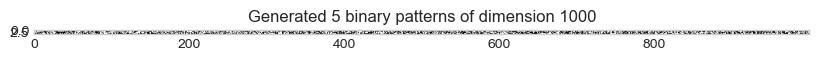

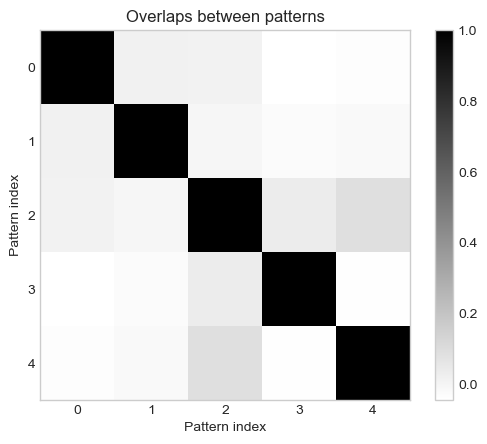

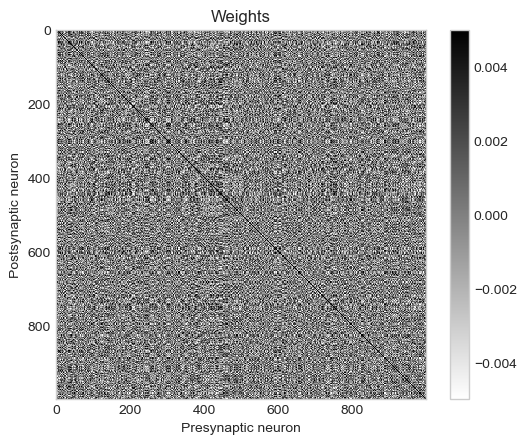

In [2]:
NETWORK_DIM = 1000
N_PATTERNS = 5
T = 50
betas = [1.5, 2.5, 3.5]
patterns = utils.get_n_binary_patterns(n_patterns=N_PATTERNS, pattern_dim=NETWORK_DIM, plot_patterns_overlaps=True, plot_patterns=True)
weights = utils.get_weights(patterns, show_weights=True)

## 3.1

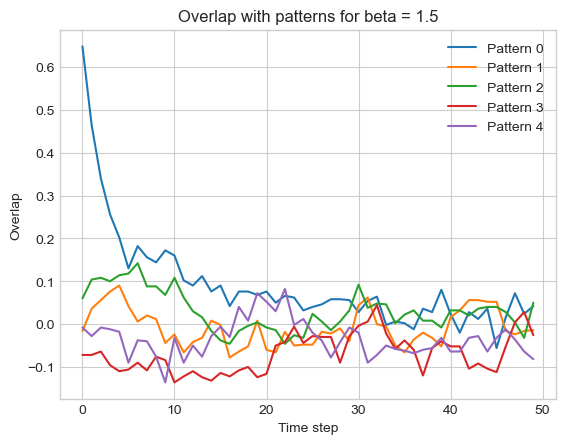

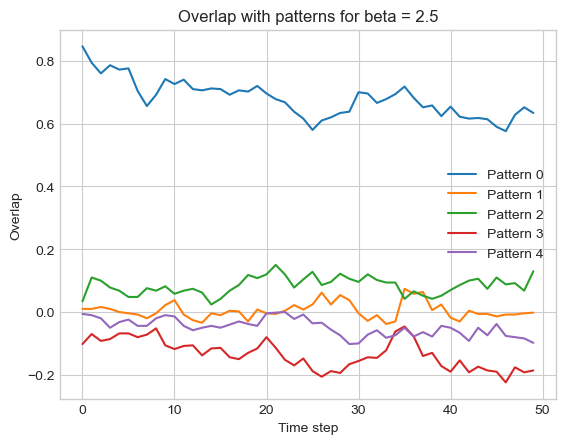

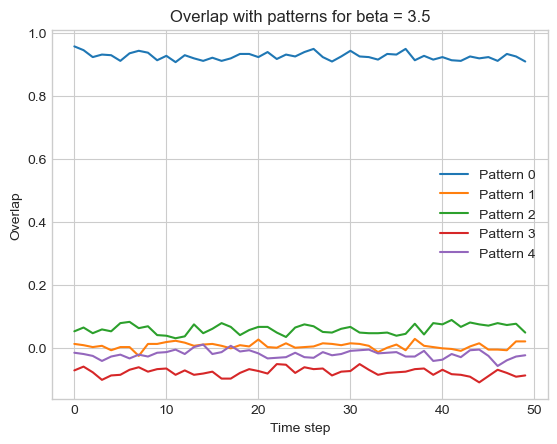

In [3]:
for idx, beta in enumerate(betas):
    cs = (patterns[0].copy() + 1)/2
    overlaps = []
    for t in range(T):
        cs = utils.compute_next_state_stochastic(cs, weights, beta)
        overlaps_t = [utils.overlap_stochastic(cs, patterns[i]) for i in range(len(patterns))]
        overlaps.append(overlaps_t)
    
    overlaps = np.array(overlaps).T
    plt.figure()
    for i, overlap in enumerate(overlaps):
        plt.plot(overlap, label=f'Pattern {i}')
    plt.title(f'Overlap with patterns for beta = {beta}')
    plt.xlabel('Time step')
    plt.ylabel('Overlap')
    plt.legend()
    

## 3.2

In [4]:
def run_net(init_state, weights, beta, n_steps):
    cs = init_state.copy()
    states = []
    for t in range(n_steps):
        states.append(cs.copy())
        cs = utils.compute_next_state_stochastic(cs, weights, beta)
    return np.array(states)

In [5]:
def get_simul_overlaps(states, patterns):
    overlaps = np.zeros((len(patterns), len(states)))
    for state_idx, state in enumerate(states):
        for pattern_idx, pattern in enumerate(patterns):
            overlap = utils.overlap_stochastic(state, pattern)
            overlaps[pattern_idx, state_idx] = overlap
    return overlaps

In [6]:
def check_successful_storage(n_patterns, pattern_dim, beta, n_steps, threshold_step):
    assert n_steps > threshold_step, " total number of steps must be greater than threshold step"
    patterns = utils.get_n_binary_patterns(n_patterns=n_patterns, pattern_dim=pattern_dim)
    weights = utils.get_weights(patterns)
    for pattern_idx, p in enumerate(patterns):
        init_state = (p.copy() + 1) / 2
        states = run_net(init_state, weights, beta, n_steps)
        relevant_states = states[-threshold_step:]
        overlaps = get_simul_overlaps(relevant_states, patterns)
        assert overlaps.shape == (n_patterns, threshold_step),\
            f"overlaps shape is not correct, expected {n_patterns, threshold_step}, got {overlaps.shape}"
        # pattern is retrieved if mean overlap of pattern is greater than all other patterns
        mean_overlaps = np.mean(overlaps, axis=1)
        if np.argmax(mean_overlaps) != pattern_idx:
            return False
    return True

In [7]:
betas = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
N_TRIALS = 5


trial_results = np.zeros((N_TRIALS, len(betas)))
for trial in tqdm(range(N_TRIALS)):
    for beta_idx, beta in enumerate(betas):
        P = 1
        while True:
            
            storage_success = check_successful_storage(
                n_patterns=P,
                pattern_dim=NETWORK_DIM,
                beta=beta,
                n_steps=T,
                threshold_step=10,
            )
            if not storage_success:
                break
            P *= 2

        low = P // 2
        p_max = low
        for P_lin in range(low + 1, P):
            
            storage_success = check_successful_storage(
                n_patterns=P_lin,
                pattern_dim=NETWORK_DIM,
                beta=beta,
                n_steps=T,
                threshold_step=10,
            )
                    
            if not storage_success:
                p_max = P_lin - 1
                break
            else:
                p_max = P_lin
                
        trial_results[trial, beta_idx] = p_max

  0%|          | 0/5 [00:00<?, ?it/s]

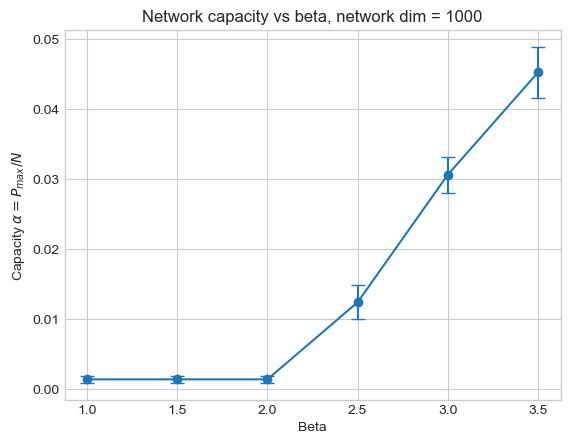

In [8]:
mean_p_max = np.mean(trial_results, axis=0)
std_p_max = np.std(trial_results, axis=0)

mean_alpha = mean_p_max / NETWORK_DIM
std_alpha = std_p_max / NETWORK_DIM


plt.errorbar(betas, mean_alpha, yerr=std_alpha, fmt='o-', capsize=5)

plt.title(f"Network capacity vs beta, network dim = {NETWORK_DIM}")
plt.xlabel("Beta")
plt.ylabel(r'Capacity $\alpha = P_{max}/N$')

plt.show()


## 3.3

In [3]:
NETWORK_DIM = 1000
N_PATTERNS = 5
T = 20
BETA = 7

patterns = utils.get_n_binary_patterns(n_patterns=N_PATTERNS, pattern_dim=NETWORK_DIM)
weights = utils.get_weights(patterns)

cs = (patterns[0].copy() + 1)/2
overlaps = []
states = []
for t in range(T):
    states.append(cs.copy())
    cs = utils.compute_next_state_stochastic_refractory(cs, weights, BETA)
    overlaps_t = [utils.overlap_stochastic(cs, patterns[i]) for i in range(len(patterns))]
    overlaps.append(overlaps_t)
overlaps = np.array(overlaps).T
states = np.array(states).T
overlaps.shape, states.shape

((5, 20), (1000, 20))

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

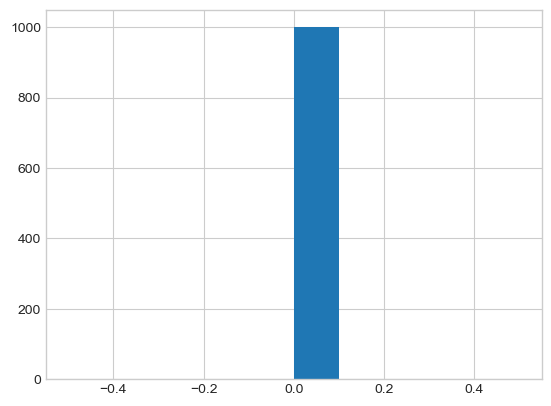

In [4]:
plt.hist(states[:, 1])

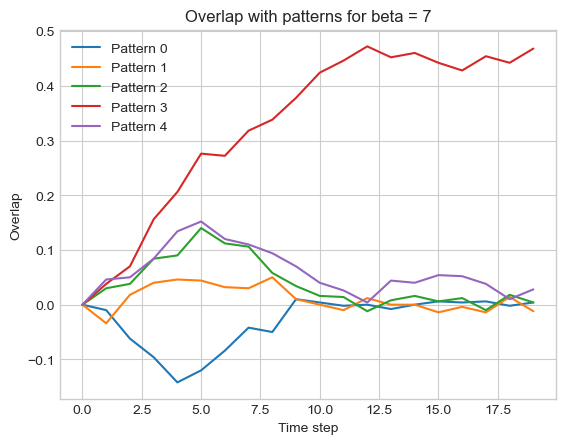

In [5]:
plt.figure()
for i, overlap in enumerate(overlaps):
    plt.plot(overlap, label=f'Pattern {i}')
plt.title(f'Overlap with patterns for beta = {BETA}')
plt.xlabel('Time step')
plt.ylabel('Overlap')
plt.legend()

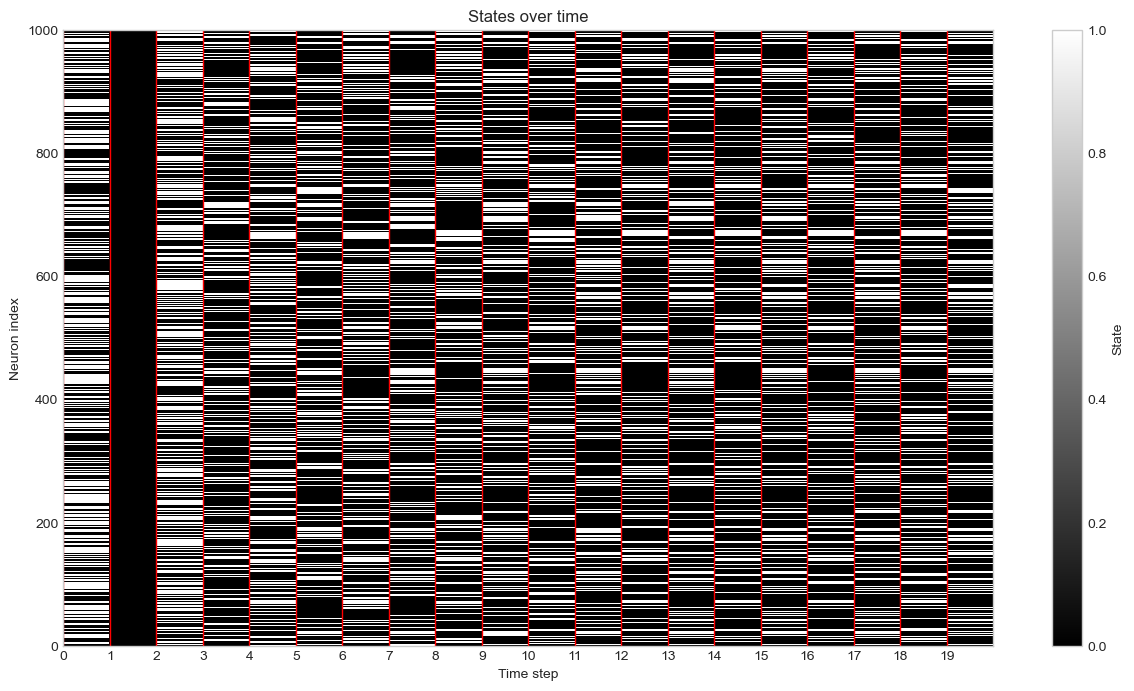

In [6]:

plt.figure(figsize=(15, 8))
plt.imshow(states, aspect='auto', cmap='gray', extent=[0, states.shape[1], 0, states.shape[0]], interpolation='nearest')
plt.xticks(np.arange(states.shape[1]))
plt.grid(False)
plt.grid(which='major', axis='x', linestyle='-', linewidth=1, color='red')
plt.title('States over time')
plt.xlabel('Time step')
plt.ylabel('Neuron index')
plt.colorbar(label='State')
